<a href="https://colab.research.google.com/github/sudipta-on/Quantum-Many-Body-Problem-using-Netket/blob/main/Ising_Model_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Ground-State: Ising Model 1D}$$

$\qquad \qquad \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \text{ - Sudipta Majumder}$

$24 $ $\text{June},2024$

In this problem, we will study the transverse-field Ising model in one dimension:

$$
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}.
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$, and $\Gamma$ represents the magnetic moment.

## 0. Installing Netket

Installing NetKet is relatively straightforward. We can just install `NetKet` using pip by following the below code:

In [33]:
!pip install netket --quiet

In Google Colab we have a special feature where we can switch the running field of the notebook just by changing the field by "cpu" to "gpu" or vice-versa.
But we'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [34]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [35]:
import netket as nk
print(f"NetKet version: {nk.__version__}")   # printing NetKet current version

import time

NetKet version: 3.13.0


## 1. Defining the Hamiltonian

In the first step we have to define our Hamiltonian problem.
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifyling the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins.

In [36]:
N = 20 # no. of spins

hi = nk.hilbert.Spin(s= 1/2,N=N) # Hilbert space of 20 spins

In [37]:
import jax
hi.random_state(jax.random.PRNGKey(0),3) # randomizing the Hilbert space

Array([[ 1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,
         1.,  1.,  1., -1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
         1.,  1.,  1., -1.,  1., -1.,  1.]], dtype=float32)

Now we need to specify the Hamiltonian. For this purpose, we use NetKet's `LocalOperator` which is the sum of arbitrary k-local operators.

In this case, we have a 1-local operator, $\sigma^{(x)}_i$ and a two-local operator,  $\sigma^{(z)}_i \sigma^{(z)}_j$. For that we start importing the Pauli operators.



In [38]:
from netket.operator.spin import sigmax, sigmaz

We now take $\Gamma = -1$ and start defining the 1-local parts of the Hamiltonian.

In [39]:
Gamma = -1
H_0 = sum([Gamma*sigmax(hi, i) for i in range(N)])    # 1-local hamiltonian

We now define the 2-local Hamiltonian by summing up the interaction terms.


In [40]:
V = -1
H_I = sum([V*sigmaz(hi, i)*sigmaz(hi, (i+1)%N) for i in range(N)]) # 2-local hamiltonian

The final Hamiltonian becomes $\hat H = \hat H_0 + \hat H_I$

In [41]:
H = H_0 + H_I   # Total Hamiltonian
print(H)

LocalOperator(dim=20, #acting_on=40 locations, constant=0.0, dtype=float64)


## 2. Exact Diagonalization

Since the number of spins is large but still manageable for exact diagonalization, the Hamiltonian shuld be diagonalized.

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $.

In [42]:
sp_h = H.to_sparse() # converting the Hamiltonian into a sparse matrix
sp_h.shape

(1048576, 1048576)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [43]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which='SA')

print(f"eigenvaules with scipy sparse: {eig_vals}")
E_gs = eig_vals[0]
print(f"The ground-state energy: {E_gs} ")

eigenvaules with scipy sparse: [-25.49098969 -25.41240947]
The ground-state energy: -25.490989686364863 


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz:

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized:

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive.

For the normalized single-spin probability we will take a sigmoid form:

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$ thus depending on the real-valued variational parameter $\lambda$.

In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_.

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$ where $\theta$ is a set of parameters.

In this case, the parameter of the model will be just one: $\gamma$.  

In [44]:
# numerical operations in the model should always use jax.numpy instead of numpy because jax supports computing derivatives.

import jax.numpy as jnp
import flax  # Flax is a framework to define model using jax
import flax.linen as nn  # Flax.linen is a submodule of flax. It's a repository of layers, initializers, and nonlinear functions.

class MF(nn.Module):
    @nn.compact
    def __call__(self,x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        # computing the probabilities
        p = nn.log_sigmoid(lam*x)
        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result.

To actually create a variational state with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State.
To do this, we first need to define a sampler.

In `netket.sampler` several samplers are defined, each with its own peculiarities.
In the following example, we will be using a simple sampler that flips the spins in the configurations one by one.

In [45]:
# Create an instance of the model
mf_model = MF()

# Create a local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construction of the variational state using the model and the sampler
vstate = nk.vqs.MCState(sampler, mf_model,n_samples=512)

In [46]:
# One can inspect the parameters which contain the single variational parameter `lambda`
print(vstate.parameters)

{'lambda': Array([0.00601351], dtype=float64)}


In [47]:
# Expectation value
E = vstate.expect(H)
print(E)

-20.16 ± 0.19 [σ²=19.19, R̂=1.0238]


In [48]:
# the energy (expectation value) is a structure with a lot of fields.
print(f"Mean                  : {E.mean}")
print(f"Error                 : {E.error_of_mean}")
print(f"Variance              : {E.variance}")
print(f"Convergence indicator : {E.R_hat}")
print(f"Correlation time      : {E.tau_corr}")

Mean                  : -20.164082434928964
Error                 : 0.193601576893089
Variance              : 19.19056413465121
Convergence indicator : 1.02377305232401
Correlation time      : 0.0


In [49]:
vstate.expect_and_grad(H)   # return expectation and it's gradient

(-20.16 ± 0.19 [σ²=19.19, R̂=1.0238],
 {'lambda': Array([-0.08800718], dtype=float64)})

## 4. Variational Monte Carlo Method

We will now try to optimise $ \lambda $ in order to best approximate the ground state of the hamiltonian.

At first, we'll try to do this by ourself by writing the training loop, but then we'll switch to using a pre-made solution provided by netket for simplicity.

### A. DIY Optimisation Loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.

You can do so as follows:

In [50]:
from tqdm import tqdm  # tqdm helps us to visualize the progress in form of progress bar)

energy_history = []
n_steps = 600
start = time.time()
for i in tqdm(range(n_steps)):
    # compute the energy and the gradient
    E, E_grad = vstate.expect_and_grad(H)
    energy_history.append(E.mean.real)
    new_params = jax.tree.map(lambda x,y: x - 0.05 * y, vstate.parameters, E_grad)
    vstate.parameters = new_params
end = time.time()
diy_time = end - start
print("\n## DIY Optimization Loop")
print(f"Time taken: {diy_time} seconds")

100%|██████████| 600/600 [00:08<00:00, 68.81it/s]


## DIY Optimization Loop
Time taken: 8.723824262619019 seconds


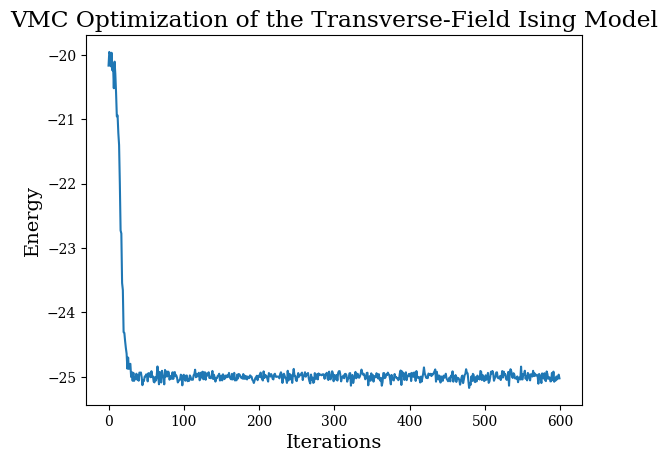

In [51]:
# We now can plot the energy during those optimisation steps:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rc('font', family = 'Serif', size = 14)
matplotlib.rc('xtick', labelsize = 10)
matplotlib.rc('ytick', labelsize = 10)

plt.plot(energy_history)
plt.title("VMC Optimization of the Transverse-Field Ising Model")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.show()

### B. Using NetKet's optimisation driver


In [52]:
# reset the parameters to run optimization again
vstate.init_parameters()
# define the optimize
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
#build the optimisation drive
gs = nk.driver.VMC(H, optimizer,variational_state = vstate)

start = time.time()
# running the driver for 300 iterations
gs.run(600)
end = time.time()
sgd_time = end - start
print("## Stochastic gradient descent(SGD) Optimization")
print(f"Time taken: {sgd_time} seconds")

mf_energy = vstate.expect(H)
error = abs((mf_energy.mean - eig_vals[0])/eig_vals[0])
print(f"Optimized energy  : {mf_energy.mean}")
print(f"Relative error    : {error}")

  0%|          | 0/600 [00:00<?, ?it/s]

## Stochastic gradient descent(SGD) Optimization
Time taken: 14.248298168182373 seconds
Optimized energy  : -24.948095019341977
Relative error    : 0.02129751232504244


In [53]:
print(f"Final Optimized parameters: {vstate.parameters['lambda']}")

Final Optimized parameters: [2.65082446]


In [54]:
eig_vals[0]

-25.490989686364863

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 2% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz.

We will now take a short-range Jastrow ansatz, entangling nearest and next-to nearest neighbors, of the form

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_i J_1 \sigma^{z}_i\sigma^{z}_{i+1} + J_2 \sigma^{z}_i\sigma^{z}_{i+2} \right),$$

where the parameters $J_1$ and $J_2$ are to be learned.

Again we can write the model using flax.

In [55]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self,x):
        j1 = self.param("J1", nn.initializers.normal(), (1,), float)
        j2 = self.param("J2", nn.initializers.normal(), (1,), float)
        # computing the nearest neighbour correlations
        corr1 = x * jnp.roll(x, -1, axis = -1)
        corr2 = x * jnp.roll(x, -2, axis = -1)
        # sum the output
        return jnp.sum(j1 * corr1 + j2 * corr2, axis = -1)

model = Jastrow()
vstate = nk.vqs.MCState(sampler, model,n_samples=1024)

In [56]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

log = nk.logging.RuntimeLog()

start = time.time()
gs.run(n_iter = 300, out = log)
end = time.time()
jas_time = end - start
print("## Jastrow Ansatz")
print(f"Time taken: {jas_time} seconds")

print(f"Final optimized parameters: j1={vstate.parameters['J1']}, J2={vstate.parameters['J2']}")

jas_energy=vstate.expect(H)
jas_error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {jas_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Jastrow Ansatz
Time taken: 9.573426485061646 seconds
Final optimized parameters: j1=[0.2352327], J2=[0.0805414]
Optimized energy : -25.280 ± 0.022 [σ²=0.410, R̂=1.0141]
relative error   : 0.008295862183797697


In [57]:
data_jastrow = log.data
print(data_jastrow)

{'acceptance': History(
   keys  = ['value'], 
   iters = [0, 1, ... 298, 299] (300 steps),
), 'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


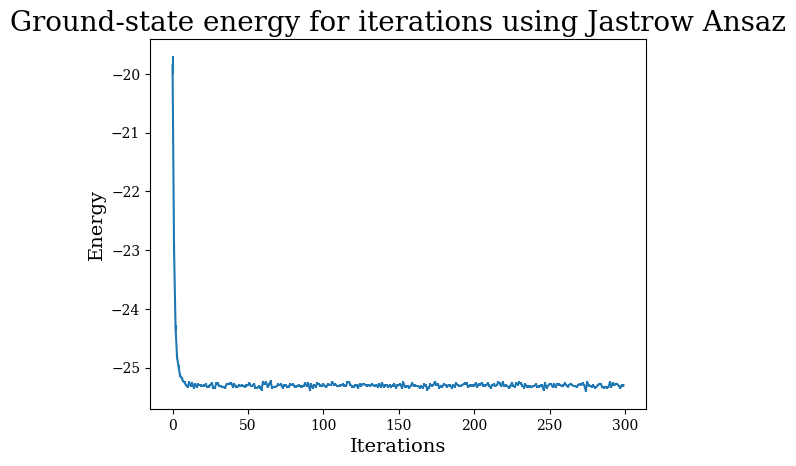

In [58]:
from matplotlib import pyplot as plt

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma)
plt.title("Ground-state energy for iterations using Jastrow Ansaz", fontsize = 20)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.show()

## 6. Neural-Network Quantum State

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation.

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer.

In [59]:
class FFN(nn.Module):
    alpha : int = 1 # number of hidden units
    @nn.compact
    def __call__(self, x):
        dense = nn.Dense(features = self.alpha * x.shape[-1])
        y = dense(x)
        y = nn.relu(y)
        return jnp.sum(y, axis=-1)

model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [60]:
optimizer = nk.optimizer.Sgd(learning_rate = 0.1)

gs = nk.driver.VMC(H, optimizer, variational_state = vstate, preconditioner = nk.optimizer.SR(diag_shift = 0.1))
log = nk.logging.RuntimeLog()

start = time.time()
gs.run(n_iter = 300, out = log)
end = time.time()
ffn_time = end - start
print("## Feed-Forward Network Model")
print(f"Time taken: {ffn_time} seconds")

ffn_energy = vstate.expect(H)
ffn_error = abs((ffn_energy.mean - eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {ffn_energy}")
print(f"relative error   : {ffn_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Feed-Forward Network Model
Time taken: 11.996768236160278 seconds
Optimized energy : -25.480 ± 0.012 [σ²=0.137, R̂=1.0129]
relative error   : 0.0004396340452236432


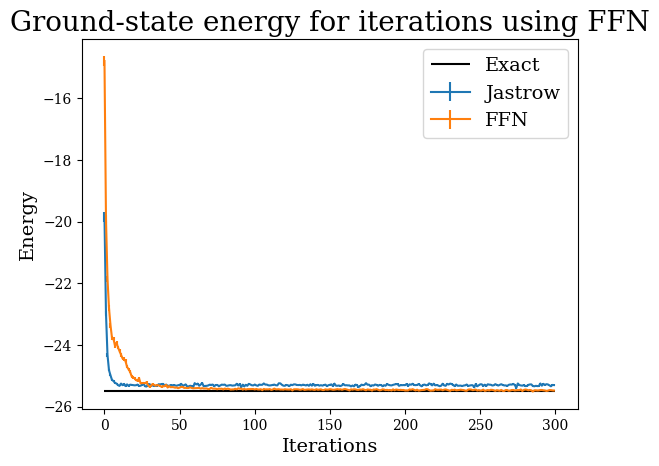

In [61]:
data_FFN = log.data

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()
plt.title("Ground-state energy for iterations using FFN", fontsize = 20)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.show()

## 7. Restricted Boltzmann Machine (RBM)
We will now consider another celebrated ansatz, the Restricted Boltzmann Machine (RBM). It simply consists of two layers: a visible one representing the $L$ spin 1/2 degrees of freedom, and an hidden one which contains a different number $M$ of hidden units. There are connections between all visible and hidden nodes.

$\Psi_{\rm RBM} (\sigma_1^z,\sigma_2^z, ..., \sigma_L^z)  = \exp ( \sum_{i=1}^L a_i \sigma_i^z ) \prod_{i=1}^M \cosh (b_i + \sum_j W_{ij} \sigma^z_j)$

$a_i$ (resp. $b_i$) are the visible (resp. hidden) bias. Together with the weights $W_{ij}$, they are variational parameters that we (or rather NetKet) will optimize to minimize the energy. Netket gives you the control on the important parameters in this ansatz, such as $M$ and the fact that you want to use or not the biases.

More conveniently (especially if you want to try another $L$ in this tutorial), let's define the hidden unit density $\alpha = M / L$, and invoke the RBM ansatz in NetKet with as many hidden as visible units.

In [62]:

# Define the transverse-field Ising Hamiltonian
graph = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)

# Define the neural network model (RBM)
alpha = 1  # hidden units per visible unit

model = nk.models.RBM(alpha=alpha)

# Define the Metropolis-Hastings sampler
sampler = nk.sampler.MetropolisLocal(hilbert=hi)

# Define the variational state
vs = nk.vqs.MCState(sampler=sampler, model=model)

# Define the optimizer
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Define the stochastic reconfiguration (SR) method
sr = nk.optimizer.SR(diag_shift=0.1)
log = nk.logging.RuntimeLog()

# Run the VMC optimization
gs = nk.VMC(hamiltonian=H, optimizer=optimizer, variational_state=vs, preconditioner=sr)

start = time.time()
gs.run(n_iter=300, out=log)
end = time.time()
rbm_time = end - start
print("## Restricted Boltzmann Machine (RBM)")
print(f"Time taken: {rbm_time} seconds")

rbm_energy = vs.expect(H)
rbm_error = abs((rbm_energy.mean - eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {rbm_energy}")
print(f"relative error   : {rbm_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Restricted Boltzmann Machine (RBM)
Time taken: 15.270726203918457 seconds
Optimized energy : -25.4919 ± 0.0060 [σ²=0.0357, R̂=1.0050]
relative error   : 3.589622176503262e-05


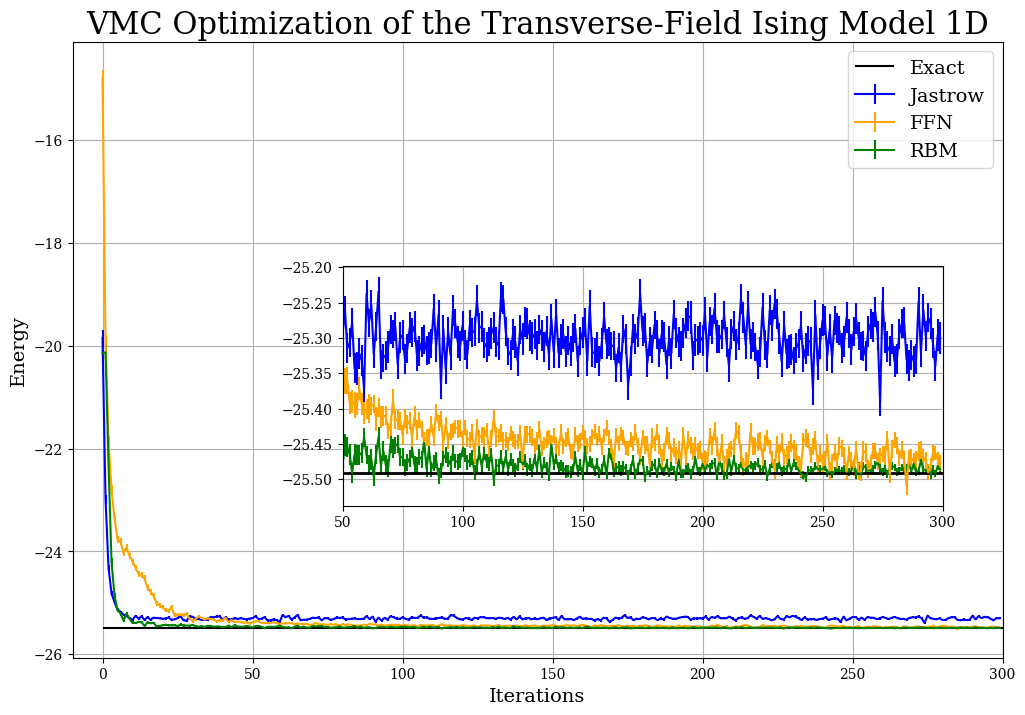

In [63]:
data_RBM = log.data

plt.figure(figsize=(12, 8))
plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean,c= 'b', yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean,c= 'orange', yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.errorbar(data_RBM["Energy"].iters, data_RBM["Energy"].Mean,c = 'g', yerr=data_RBM["Energy"].Sigma, label="RBM")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()
plt.title("VMC Optimization of the Transverse-Field Ising Model 1D", fontsize = 22)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.grid()
plt.xlim(-10,300)
#Zoomed Portion
sub_axes = plt.axes([0.35,0.3,0.5,0.3])
sub_axes.errorbar(data_RBM["Energy"].iters[50:], data_RBM["Energy"].Mean[50:],c= 'g',yerr = data_RBM["Energy"].Sigma[50:])
sub_axes.errorbar(data_jastrow["Energy"].iters[50:], data_jastrow["Energy"].Mean[50:],c ='b',yerr = data_jastrow["Energy"].Sigma[50:])
sub_axes.errorbar(data_FFN["Energy"].iters[50:], data_FFN["Energy"].Mean[50:],c = 'orange',yerr = data_FFN["Energy"].Sigma[50:])
sub_axes.axhline(y=eig_vals[0], xmin=0, xmax=data_RBM["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlim(50,300)
plt.grid()
plt.show()

## 8. Translation Symmetry

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers.

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group.


In [64]:
graph = nk.graph.Chain(length = N, pbc = True)

print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


In [65]:
# Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as
Gamma, V = -1, -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)]) + sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

We now write a model with an invariant transformation given by the translation group. Notice that we will now use NetKet's own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [66]:
import netket.nn as nknn

class SymmModel(nn.Module):
    alpha : int
    @nn.compact
    def __call__(self,x):
        # Reshape the input to include a features dimension
        x = x.reshape(x.shape[0], 1, x.shape[1])  # (batch, 1, n_sites)
        x = nknn.DenseSymm(symmetries = graph.translation_group(),
                           features = self.alpha,
                           kernel_init = nn.initializers.normal(stddev=0.01))(x)

        x = nn.relu(x)
        return jnp.sum(x, axis = (-1,-2))

sampler = nk.sampler.MetropolisLocal(hi)
model = SymmModel(alpha = 4)
vstate = nk.vqs.MCState(sampler, model, n_samples = 1024)
vstate.n_parameters

84

In [67]:
optimizer = nk.optimizer.Sgd(learning_rate = 0.1)

gs = nk.driver.VMC(H, optimizer, variational_state = vstate, preconditioner = nk.optimizer.SR(diag_shift = 0.1))
log = nk.logging.RuntimeLog()

start = time.time()
gs.run(n_iter = 600,out=log)
end = time.time()
symm_time = end - start
print("## Stochastic gradient descent(SGD) Optimization")
print(f"Time taken: {symm_time} seconds")

symm_energy = vstate.expect(H)
symm_error = abs((symm_energy.mean - eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {symm_energy}")
print(f"relative error   : {symm_error}")

  0%|          | 0/600 [00:00<?, ?it/s]

## Stochastic gradient descent(SGD) Optimization
Time taken: 79.06457686424255 seconds
Optimized energy : -25.4890 ± 0.0020 [σ²=0.0041, R̂=1.0090]
relative error   : 7.901082901995096e-05


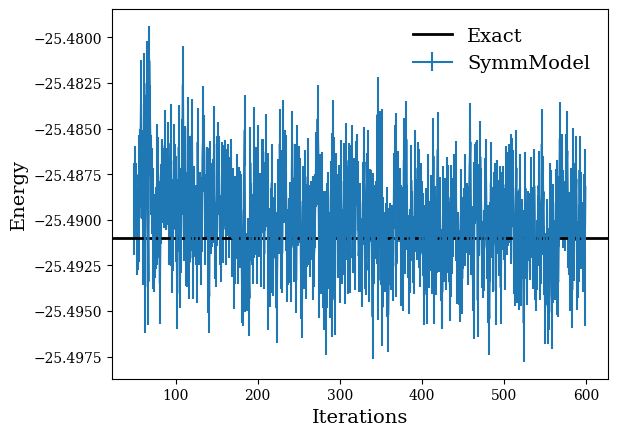

In [68]:
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")

plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)
plt.show()

## 9. Comparing Runtime and Relative error for same number of iteration
Now let us compare time required for different methods/ ansatz for same number of iterations (n = 300).



In [69]:
print("Time required for Differnt Optimization methods")
print("------------------------------------------------------------------")
print(f"SGD       : {sgd_time} seconds")
print(f"DIY       : {diy_time} seconds")
print("------------------------------------------------------------------")

Time required for Differnt Optimization methods
------------------------------------------------------------------
SGD       : 14.248298168182373 seconds
DIY       : 8.723824262619019 seconds
------------------------------------------------------------------


In [70]:
print("Time Required for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Jastrow   : {jas_time} seconds")
print(f"FFN       : {ffn_time} seconds")
print(f"RBM       : {rbm_time} seconds")
print(f"SymmModel : {symm_time} seconds")
print("------------------------------------------------------------------")

Time Required for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Jastrow   : 9.573426485061646 seconds
FFN       : 11.996768236160278 seconds
RBM       : 15.270726203918457 seconds
SymmModel : 79.06457686424255 seconds
------------------------------------------------------------------


In [71]:
print("Relative error for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Jastrow   : {jas_error}")
print(f"FFN       : {ffn_error}")
print(f"RBM       : {rbm_error}")
print(f"SymmModel : {symm_error}")
print("------------------------------------------------------------------")

Relative error for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Jastrow   : 0.008295862183797697
FFN       : 0.0004396340452236432
RBM       : 3.589622176503262e-05
SymmModel : 7.901082901995096e-05
------------------------------------------------------------------


## 10. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $X-X$ correlator.
Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement.


In [72]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])
vstate.n_samples = 400000
vstate.expect(corr)

10.910 ± 0.016 [σ²=31.401, R̂=1.0001]

In [73]:
psi = eig_vecs[:,0]
exact_corr=psi@(corr.to_sparse()@psi)
print(exact_corr)

10.852248713127988


## Carleo Result

In [74]:
from netket.operator.spin import sigmax, sigmaz

class FNN(nn.Module):
    alpha : int = 1 # number of hidden units
    @nn.compact
    def __call__(self, x):
        dense = nn.Dense(features = self.alpha * x.shape[-1])
        y = dense(x)
        y = nn.relu(y)
        return jnp.sum(y, axis=-1)

Carleo_result_log = {}

def Carleo_Result(Nspins, Hfield , alpha, V = -1):
  hi = nk.hilbert.Spin(s= 1/2,N=Nspins) # Hilbert space of Nspins
  H = -sum([Hfield*sigmax(hi,i) for i in range(N)]) + sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)]) #defining Hamiltonian
  sp_h=H.to_sparse() # converting the Hamiltonian into a sparse matrix
  eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
  sampler = nk.sampler.MetropolisLocal(hi) # Create the local sampler on the hilbert space
  Energy = []
  Error = []
  for a in alpha:
    model = FNN(alpha=a)
    vstate = nk.vqs.MCState(sampler, model, n_samples=1008)
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))
    gs.run(n_iter = 500, out=f"Ising_1D_{Nspins}_{Hfield}_{a}".replace(".","_"))
    energy=vstate.expect(H)
    error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
    Energy.append(energy)
    Error.append(error)

    print(f"Result for N_spin : {Nspins}, Hfield : {Hfield}, alpha = {a}")
    print(f"Exact Energy : {eig_vals[0]}")
    print(f"Optimized energy : {energy}")
    print(f"relative error   : {error}")
  Carleo_result_log[f"{Nspins}_{Hfield}"] = {
        "Energy" : Energy,
        "Error" : Error
  }

Nspin_list = [20]
Hfield_list = [0.5, 1, 2]
alpha = [1, 2, 3, 4]

for Nspins in Nspin_list:
  for Hfield in Hfield_list:
    Carleo_Result(Nspins, Hfield, alpha = alpha, V = -1 )

  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 0.5, alpha = 1
Exact Energy : -21.270888306919257
Optimized energy : -21.2518 ± 0.0080 [σ²=0.0651, R̂=1.0126]
relative error   : 0.18845624048408624


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 0.5, alpha = 2
Exact Energy : -21.270888306919257
Optimized energy : -21.1987 ± 0.0051 [σ²=0.0259, R̂=1.0107]
relative error   : 0.18845624048408624


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 0.5, alpha = 3
Exact Energy : -21.270888306919257
Optimized energy : -18.836 ± 0.017 [σ²=0.278, R̂=1.0090]
relative error   : 0.18845624048408624


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 0.5, alpha = 4
Exact Energy : -21.270888306919257
Optimized energy : -21.112 ± 0.013 [σ²=0.162, R̂=1.0299]
relative error   : 0.18845624048408624


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 1, alpha = 1
Exact Energy : -25.490989686364713
Optimized energy : -25.435 ± 0.012 [σ²=0.147, R̂=1.0033]
relative error   : 0.008295862183791892


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 1, alpha = 2
Exact Energy : -25.490989686364713
Optimized energy : -22.1978 ± 0.0037 [σ²=0.0141, R̂=1.0154]
relative error   : 0.008295862183791892


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 1, alpha = 3
Exact Energy : -25.490989686364713
Optimized energy : -25.465 ± 0.015 [σ²=0.216, R̂=1.0093]
relative error   : 0.008295862183791892


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 1, alpha = 4
Exact Energy : -25.490989686364713
Optimized energy : -23.046 ± 0.010 [σ²=0.105, R̂=1.0092]
relative error   : 0.008295862183791892


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 2, alpha = 1
Exact Energy : -42.54177661383844
Optimized energy : -42.543 ± 0.010 [σ²=0.105, R̂=1.0071]
relative error   : 0.40577187975795576


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 2, alpha = 2
Exact Energy : -42.54177661383844
Optimized energy : -42.5416 ± 0.0013 [σ²=0.0018, R̂=1.0125]
relative error   : 0.40577187975795576


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 2, alpha = 3
Exact Energy : -42.54177661383844
Optimized energy : -32.3858 ± 0.0015 [σ²=0.0022, R̂=1.0070]
relative error   : 0.40577187975795576


  0%|          | 0/500 [00:00<?, ?it/s]

Result for N_spin : 20, Hfield : 2, alpha = 4
Exact Energy : -42.54177661383844
Optimized energy : -34.4837 ± 0.0012 [σ²=0.0014, R̂=1.0039]
relative error   : 0.40577187975795576


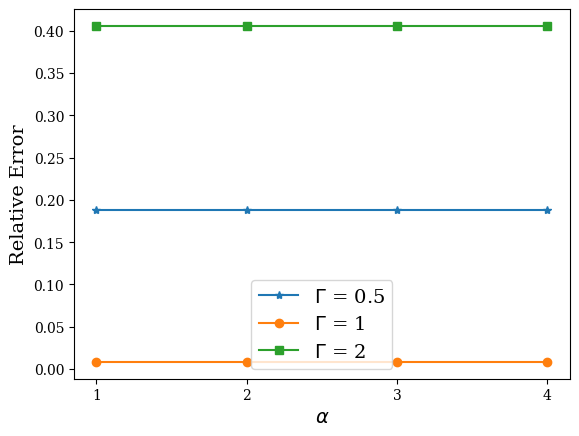

In [75]:
# ploting relative errors

# For N_spins = 20,
errors_H_05 = Carleo_result_log["20_0.5"]["Error"]
errors_H_1 = Carleo_result_log["20_1"]["Error"]
errors_H_2 = Carleo_result_log["20_2"]["Error"]
# errors_H_25 = Carleo_result_log["20_0.25"]["Error"]

# plt.errorbar(alpha, errors_H_25,marker = "o", label="$\Gamma$ = 0.25")
plt.errorbar(alpha, errors_H_05, marker = "*",label="$\Gamma$ = 0.5")
plt.errorbar(alpha, errors_H_1, marker = "o",label="$\Gamma$ = 1")
plt.errorbar(alpha, errors_H_2, marker = "s",label="$\Gamma$ = 2")
plt.legend()
plt.xlabel("$\\alpha$")
plt.ylabel('Relative Error')
# plt.ylim(0,0.02)
plt.xticks(alpha)
plt.show()
